
# Recommender System using Supervised Graph Neural Networks

## Overview
This project implements a recommender system using supervised learning techniques with Graph Neural Networks (GNNs). The approach leverages the inherent structure of the data and supervised learning of **LightGCN** to enhance the recommendation quality without relying on labeled data.

## Features
- supervised learning with LightGCN (GNN)
- Efficient handling of graph-structured data
- Enhanced recommendation performance through advanced neural network techniques

## Usage
To run the project, execute the following command:
```sh
jupyter notebook recommender-system-using-supervised-gnn.ipynb
```

## Project Structure
- `recommender-system-using-supervised-gnn.ipynb`: Main notebook containing the implementation of the recommender system.

## Results
The results of the recommender system are evaluated using standard metrics such as Precision, Recall, and F1-score. The supervised approach shows significant improvements over traditional methods.

## Contributing
Contributions are welcome! Please read the [contribution guidelines](CONTRIBUTING.md) first.


In [73]:
# Code cell
!pip install torch-geometric

In [108]:
# Import necessary libraries
import numpy as np
import pandas as pd
import random
import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
from torch_geometric.utils import degree
import torch
from torch import nn, optim, Tensor
# from torch_sparse import SparseTensor, matmul
import torch.nn.functional as F
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.data import download_url, extract_zip
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
from collections import defaultdict
from scipy import sparse

In [75]:
# Code cell
R = np.array([[0,0,1,1],[1,0,1,0],[0,1,0,0]])
print(R)

[[0 0 1 1]
 [1 0 1 0]
 [0 1 0 0]]


In [76]:
# Code cell
R_np_COO = sparse.coo_matrix(R)
print(R_np_COO)

  (0, 2)	1
  (0, 3)	1
  (1, 0)	1
  (1, 2)	1
  (2, 1)	1


In [77]:
# Code cell
R_edge_index = [R_np_COO.row, R_np_COO.col]
print(R_edge_index)

[array([0, 0, 1, 1, 2], dtype=int32), array([2, 3, 0, 2, 1], dtype=int32)]


In [78]:
# Code cell
print(R_np_COO.todense())

[[0 0 1 1]
 [1 0 1 0]
 [0 1 0 0]]


In [79]:
# Code cell
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
user_path = './ml-latest-small/users.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [80]:
# Code cell
df_movie = pd.read_csv(movie_path)
df_rating = pd.read_csv(rating_path)

print(df_rating.describe())
df_rating.head()

print("Movies:", len(df_rating['movieId'].unique()))
print("Users:", len(df_rating['userId'].unique()))

              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09
Movies: 9724
Users: 610


Label The movies cause movieIds are from 1 to 193609

In [81]:
# Train the model
user_labels = preprocessing.LabelEncoder()
movie_labels = preprocessing.LabelEncoder()

df_rating.userId = user_labels.fit_transform(df_rating.userId.values)
df_rating.movieId = movie_labels.fit_transform(df_rating.movieId.values)

In [82]:
# Code cell
print(df_rating.describe())

              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      325.127564    3101.735561       3.501557  1.205946e+09
std       182.618491    2627.050983       1.042529  2.162610e+08
min         0.000000       0.000000       0.500000  8.281246e+08
25%       176.000000     900.000000       3.000000  1.019124e+09
50%       324.000000    2252.000000       3.500000  1.186087e+09
75%       476.000000    5095.250000       4.000000  1.435994e+09
max       609.000000    9723.000000       5.000000  1.537799e+09


In [83]:
# Code cell
print(df_rating.rating.value_counts())

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64


## Load Edge Indices

In [84]:
# Define functions
def load_edge_csv(df, src_index_col, dest_index_col, link_index_col, threshold=3):
  edge_index = None
  sources = [user for user in df['userId']]
  destinations = [movie for movie in df['movieId']]
  link_vals = df[link_index_col].values

  edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= threshold
  edge_index = [[],[]]
  edge_values = []

  for i in range(edge_attr.shape[0]):
    if edge_attr[i]:
      edge_index[0].append(sources[i])
      edge_index[1].append(destinations[i])
      edge_values.append(link_vals[i])

  return edge_index, edge_values


In [85]:
# Code cell
edge_index, edge_values = load_edge_csv(df_rating, 'userId', 'movieId', 'rating', threshold=1)

In [86]:
# Code cell
print(f'{len(edge_index)} x {len(edge_index[0])}')

2 x 99466


In [87]:
# Code cell
edge_index = torch.LongTensor(edge_index)
edge_index.size()

torch.Size([2, 99466])

In [88]:
# Code cell
edge_values = torch.tensor(edge_values)
edge_values

tensor([4., 4., 4.,  ..., 5., 5., 3.], dtype=torch.float64)

In [89]:
# Code cell
num_movies, num_users = len(df_rating['movieId'].unique()), len(df_rating['userId'].unique())
num_interactions = edge_index.shape[1]
print(f'Number of movies: {num_movies}')
print(f'Number of users: {num_users}')
print(f'Number of interactions: {num_interactions}')

Number of movies: 9724
Number of users: 610
Number of interactions: 99466


### Splitting Dataset

In [90]:
# Train the model
all_indices = list(range(num_interactions))
train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=1)

train_edge_index = edge_index[:, train_indices]
train_edge_values = edge_values[train_indices]
val_edge_index = edge_index[:, val_indices]
val_edge_values = edge_values[val_indices]
test_edge_index = edge_index[:, test_indices]
test_edge_values = edge_values[test_indices]
print(len(train_edge_index[1]))
print(len(val_edge_index[1]))
print(len(test_edge_index[1]))

79572
9947
9947


### Conversion of Interaction matrix(R) to Adjacency Matrix(A)

In [91]:
# Define functions
def R_to_Adjacency_edge_index(edge_index, edge_values):
  R = torch.zeros((num_users, num_movies))
  for i in range(len(edge_index[0])):
    R[edge_index[0][i], edge_index[1][i]] = edge_values[i]
  R_T = torch.transpose(R, 0, 1)
  A = torch.zeros((num_users+num_movies), (num_users+num_movies))
  A[:num_users, num_users:] = R.clone()
  A[num_users:, :num_users] = R_T.clone()
  A_coo = A.to_sparse_coo()
  return A_coo.indices(), A_coo.values()

In [92]:
# Define functions
def Adjacency_edge_index_to_R_edge_index(edge_index, edge_values):
  sparse_input_edge_mat = torch.sparse_coo_tensor(edge_index, edge_values, size=(num_users + num_movies, num_users + num_movies))
  A = sparse_input_edge_mat.to_dense()
  R = A[:num_users, num_users:]
  R_COO = R.to_sparse_coo()
  R_edge_index = R_COO.indices()
  return R_edge_index, R_COO.values()

In [93]:
# Train the model
train_adj_edge_index, train_adj_edge_values = R_to_Adjacency_edge_index(train_edge_index, train_edge_values)
val_adj_edge_index, val_adj_edge_values = R_to_Adjacency_edge_index(val_edge_index, val_edge_values)
test_adj_edge_index, test_adj_edge_values = R_to_Adjacency_edge_index(test_edge_index, test_edge_values)

In [94]:
# Train the model
print(train_adj_edge_index.size())
print(val_adj_edge_index.size())
print(test_adj_edge_index.size())

torch.Size([2, 159144])
torch.Size([2, 19894])
torch.Size([2, 19894])


### Training & computing BPR Loss
Since this is Self-supervised Learning, we are relying on graph structure itself. So, we will random sample a batch of positives and negatives

In [95]:
# Define functions
def sample_mini_batch(batch_size, edge_index): # Note: edge_index is in interactive matrix form
  edges = structured_negative_sampling(edge_index)
  edges = torch.stack(edges, dim=0)
  mini_batch_sample_indices = random.choices(list(range(edges[0].shape[0])), k=batch_size)
  mini_batch_edges = edges[:, mini_batch_sample_indices]
  user_indices, positive_user_indices, negative_user_indices = mini_batch_edges[0], mini_batch_edges[1], mini_batch_edges[2]
  return user_indices, positive_user_indices, negative_user_indices

## LightGCN Model

In [96]:
# Define functions
class LightGCN(MessagePassing):
  def __init__(self, num_users, num_movies, embedding_dim=64, K=3, add_self_loops=False): # K = No.of layers
    super().__init__()
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_dim = embedding_dim
    self.K = K
    self.add_self_loops = add_self_loops

    self.user_embedding = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim)
    self.movie_embedding = nn.Embedding(num_embeddings=self.num_movies, embedding_dim=self.embedding_dim)
    self.init_embedding()
    self.out = nn.Linear(embedding_dim+embedding_dim, 1)

  def init_embedding(self):
    nn.init.normal_(self.user_embedding.weight, std=0.1)
    nn.init.normal_(self.movie_embedding.weight, std=0.1)


  def forward(self, edge_index, edge_values):
    edge_index_norm = gcn_norm(edge_index, add_self_loops=self.add_self_loops)

    emb_0 = torch.cat([self.user_embedding.weight, self.movie_embedding.weight])
    embs = [emb_0]
    emb_k = emb_0

    for i in range(self.K):
      emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
      embs.append(emb_k)

    embs = torch.stack(embs, dim=1)
    lightgcn_all_embeddings = torch.mean(embs, dim=1)

    user_embeddings, movie_embeddings = torch.split(lightgcn_all_embeddings, [self.num_users, self.num_movies])
    
    r_mat_edge_index, _ = Adjacency_edge_index_to_R_edge_index(edge_index, edge_values)
    
    src, dest = r_mat_edge_index[0], r_mat_edge_index[1]
    user_embs = user_embeddings[src]
    item_embs = movie_embeddings[dest]
    out = torch.cat([user_embs, item_embs], dim=1)
    return self.out(out)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

### Evaluation Metrics

In [113]:
# Define functions
# Get recall
def get_recall_at_k(input_edge_index, input_edge_values, pred_ratings, k=10, threshold=3.5):
    with torch.no_grad():
        user_item_rating_list = defaultdict(list)
        for i in range(len(input_edge_index[0])):
            src=input_edge_index[0][i].item()
            dest=input_edge_index[1][i].item()
            true_rating=input_edge_values[i].item()
            pred_rating=pred_ratings[i].item()
            
            user_item_rating_list[src].append((pred_rating, true_rating))
        recalls = dict()
        precisions = dict()
        for user_id, user_ratings in user_item_rating_list.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)
            n_rel = sum((true_r>=threshold) for (_, true_r) in user_ratings)
            n_rec_k = sum((est>=threshold) for (est, _) in user_ratings[:k])
            n_rel_and_rec_k = sum((est>=threshold and true_r>=threshold) for (est, true_r) in user_ratings[:k])
            precisions[user_id] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[user_id] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        overall_recall = sum(rec for rec in recalls.values())/len(recalls)
        overall_precision = sum(pre for pre in precisions.values())/len(precisions)
        
        return overall_recall, overall_precision

## Training

### Hyperparameters

In [98]:
# Code cell
ITERATIONS = 10000
EPOCHS = 10
BATCH_SIZE = 1024
K = 10
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
LAMBDA = 1e-6

### Setup

In [99]:
# Code cell
model = LightGCN(num_users, num_movies, K=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [102]:
# Train the model
model = model.to(device)

model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_adj_edge_index = train_adj_edge_index.to(device)
val_adj_edge_index = val_adj_edge_index.to(device)
test_adj_edge_index = test_adj_edge_index.to(device)

train_adj_edge_values = train_adj_edge_values.to(device)
val_adj_edge_values = val_adj_edge_values.to(device)
test_adj_edge_values = test_adj_edge_values.to(device)
loss_fn = nn.MSELoss()

In [103]:
# Train the model
r_mat_train_index, r_mat_train_values = Adjacency_edge_index_to_R_edge_index(train_adj_edge_index, train_adj_edge_values)
r_mat_test_index, r_mat_test_values = Adjacency_edge_index_to_R_edge_index(test_adj_edge_index, test_adj_edge_values)
r_mat_val_index, r_mat_val_values = Adjacency_edge_index_to_R_edge_index(val_adj_edge_index, val_adj_edge_values)

### Training loop

In [115]:
# Train the model
train_losses = []
val_losses = []
val_recall_at_k = []
val_precision_at_k = []

for iter in tqdm(range(ITERATIONS)):
  pred_ratings = model.forward(train_adj_edge_index, train_adj_edge_values)
  train_loss = loss_fn(pred_ratings, r_mat_train_values.view(-1, 1))
    
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  # val set
  if iter % ITERS_PER_EVAL == 0:
    model.eval()

    with torch.no_grad():
      val_pred_ratings = model.forward(val_adj_edge_index, val_adj_edge_values)
      val_loss = loss_fn(val_pred_ratings, r_mat_val_values.view(-1, 1)).sum()
      recall_at_k, precision_at_k = get_recall_at_k(r_mat_val_index, r_mat_val_values, val_pred_ratings, k=20)
      print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {train_loss}, val_Loss: {val_loss}, Recall: {recall_at_k}, Precision: {precision_at_k}")

      train_losses.append(train_loss.item())
      val_losses.append(val_loss.item())
      val_recall_at_k.append(recall_at_k)
      val_precision_at_k.append(precision_at_k)

    model.train()

  if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
    scheduler.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

[Iteration 0/10000] train_loss: 13.422472953796387, val_Loss: 13.458664894104004, Recall: 0.0, Precision: 0.0
[Iteration 200/10000] train_loss: 1.005832314491272, val_Loss: 1.383942723274231, Recall: 0.1707661789498549, Precision: 0.468895877850793
[Iteration 400/10000] train_loss: 0.7693952918052673, val_Loss: 1.206430196762085, Recall: 0.3541587251001714, Precision: 0.6157676729588497
[Iteration 600/10000] train_loss: 0.6509786248207092, val_Loss: 1.1792881488800049, Recall: 0.4360737275110559, Precision: 0.6269573989105723
[Iteration 800/10000] train_loss: 0.5846289396286011, val_Loss: 1.1803618669509888, Recall: 0.4897558670550156, Precision: 0.6301863094908762
[Iteration 1000/10000] train_loss: 0.5597918629646301, val_Loss: 1.1915977001190186, Recall: 0.5066265081751276, Precision: 0.6380902638598073
[Iteration 1200/10000] train_loss: 0.551003634929657, val_Loss: 1.2008744478225708, Recall: 0.5161051417068063, Precision: 0.6434238971382935
[Iteration 1400/10000] train_loss: 0.5474

## Plotting

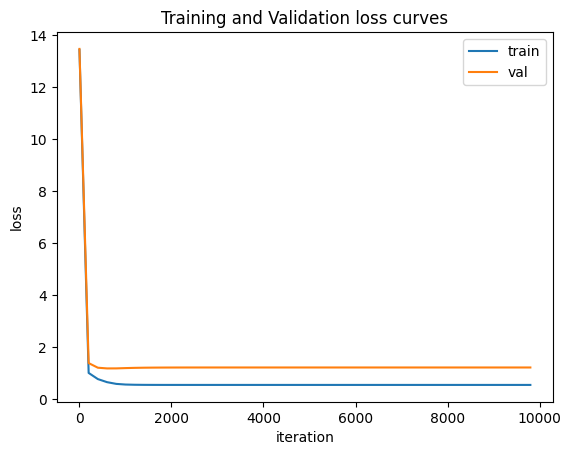

In [116]:
# Train the model
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='val')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Training and Validation loss curves')
plt.legend()
plt.show()

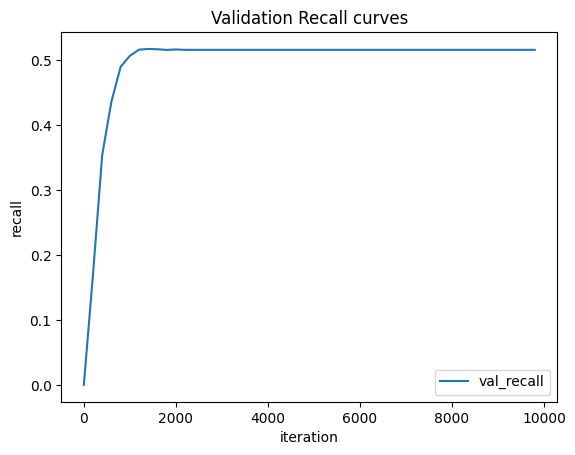

In [117]:
# Code cell
f2 = plt.figure()
plt.plot(iters, val_recall_at_k, label='val_recall')
plt.xlabel('iteration')
plt.ylabel('recall')
plt.title('Validation Recall curves')
plt.legend()
plt.show()

## Evaluation

In [120]:
# Code cell
model.eval()
with torch.no_grad():
    pred_ratings = model.forward(test_adj_edge_index, test_adj_edge_values)
    test_recall, test_precision = get_recall_at_k(r_mat_test_index, r_mat_test_values, pred_ratings, 20)
    print(f"Recall: {test_recall}, Precision: {test_precision}")

Recall: 0.5161722698902388, Precision: 0.6290730778910735
